In [1]:
import pickle
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pathlib import Path
from pvlib.irradiance import get_extra_radiation
from pvlib.solarposition import get_solarposition
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
)
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    QuantileTransformer,
)
from timezonefinder import TimezoneFinder
from tqdm import tqdm
from lightgbm import LGBMRegressor

# from models_utils.preprocessing import add_night_mark


import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

# Utilities

In [2]:
def plot_corr(df):
    for i, method in enumerate(("pearson", "spearman")):
        corr_mat = df.corr(method=method)
        mask = np.zeros_like(corr_mat, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        plt.figure(figsize=(20, 10))
        sns.heatmap(
            data=corr_mat,
            mask=mask,
            annot=True,
            fmt='.2f',
            vmax=1,
            center=0,
            square=True,
            linewidth=.5,
            cbar_kws={'shrink': .5},
        );
        plt.title(method)

In [3]:
def show_info(df: pd.DataFrame):
    display(df.head())
    # print(f"\nStart {df.time.min()}", f"End {df.time.max()}\n", sep="\n")
    display(df.info())
    print()
    df.hist(figsize=(15, 15));
    plot_corr(df)

# Constants

In [15]:
PROJECT_PATH = Path.cwd()
DATA_PATH = PROJECT_PATH / "data_5years"
WEATHER_PATH = DATA_PATH / "weather.csv"
IRRAD_PARH = DATA_PATH / "irradiance.csv"
TESLA_PATH = DATA_PATH / "tesla.csv"
PVLIB_PATH = DATA_PATH / "pvlib.csv"

LATITUDE = 51.381
LONGITUDE = 0.522
TIMEZONE = TimezoneFinder().certain_timezone_at(lat=LATITUDE, lng=LONGITUDE)

TARGET_COLUMN = "solar_power"
FEATURES_COLUMNS = ['ghi', 'dni', 'dhi',
       'temperature_2m (°C)', 'relativehumidity_2m (%)', 'rain (mm)', 'weathercode (wmo code)', 'cloudcover (%)',
       'cloudcover_low (%)', 'cloudcover_mid (%)', 'cloudcover_high (%)',
                        'shortwave_radiation (W/m²)',
       'direct_radiation (W/m²)', 'diffuse_radiation (W/m²)',
       'direct_normal_irradiance (W/m²)', "windspeed_10m (km/h)", "windspeed_100m (km/h)", "vapor_pressure_deficit (kPa)"]

TIME_COLUMN = "time"

# Data read

In [5]:
weather_data = pd.read_csv(WEATHER_PATH, parse_dates=[TIME_COLUMN], skiprows=3)
irrad_data = pd.read_csv(IRRAD_PARH, parse_dates=[TIME_COLUMN])
tesla_data = pd.read_csv(TESLA_PATH, parse_dates=[TIME_COLUMN])
pvlib_data = pd.read_csv(PVLIB_PATH, parse_dates=[TIME_COLUMN])

/tmp/ipykernel_41798/1141407469.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  weather_data = pd.read_csv(WEATHER_PATH, parse_dates=[TIME_COLUMN], skiprows=3)


# Preprocessing

In [6]:
# weather_data = weather_data.drop([i for i in range(2208, 2301)])

In [7]:
weather_data = weather_data.drop([43824])

In [8]:
weather_data['time'] = pd.to_datetime(weather_data['time'], utc = True)
irrad_data['time'] = pd.to_datetime(irrad_data['time'], utc = True)
tesla_data['time'] = pd.to_datetime(tesla_data['time'], utc = True)
pvlib_data['time'] = pd.to_datetime(pvlib_data['time'], utc = True)

In [9]:
irrad_data = irrad_data[["time", "solar_irrad"]]
solar_power_data = tesla_data[["time", "solar_power"]]
solar_power_data["solar_power"] = solar_power_data["solar_power"].clip(lower=0)

/tmp/ipykernel_41798/1124896408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  solar_power_data["solar_power"] = solar_power_data["solar_power"].clip(lower=0)


## Merge

In [10]:
merged_data = solar_power_data.merge(irrad_data, on=TIME_COLUMN)
merged_data = merged_data.merge(pvlib_data, on=TIME_COLUMN)
merged_data = merged_data.merge(weather_data, on=TIME_COLUMN)

In [11]:
merged_data = merged_data.dropna()

In [12]:
float_columns = list(merged_data.columns.values)
float_columns.remove("time")
float_columns.remove('weathercode (wmo code)')

In [13]:
merged_data[float_columns] = merged_data[float_columns].astype(float)
merged_data["weathercode (wmo code)"] = merged_data["weathercode (wmo code)"].astype(int)

In [23]:
merged_data_daily = merged_data.set_index("time")
merged_data_daily = merged_data_daily.resample('24H').mean()
# merged_data_daily = merged_data_daily.reset_index()

In [24]:
merged_data_daily = merged_data_daily.dropna()

,solar_power,solar_irrad,ghi,dni,dhi,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),precipitation (mm),rain (mm),snowfall (cm),weathercode (wmo code),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),winddirection_10m (°),winddirection_100m (°),windgusts_10m (km/h),et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa)
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-11-26 00:00:00+00:00,12.545889,0.494667,4.974410,22.508092,2.464803,5.066667,78.111111,1.577778,-0.088889,988.188889,986.111111,0.000000,0.000000,0.0,1.777778,55.222222,31.333333,40.444444,11.222222,25.777778,12.222222,13.555556,85.555556,22.688889,37.577778,295.888889,298.555556,45.188889,0.032222,0.191111
2021-11-27 00:00:00+00:00,184.994375,4.774875,44.913091,130.441837,13.668415,3.116667,87.000000,1.137500,-2.808333,991.025000,988.925000,0.204167,0.204167,0.0,35.166667,91.458333,65.541667,62.500000,36.166667,33.250000,11.875000,21.375000,47.804167,27.204167,42.937500,279.291667,282.166667,52.087500,0.023333,0.101250
2021-11-28 00:00:00+00:00,1208.000000,10.850208,44.154722,129.478348,13.441737,1.691667,75.416667,-2.262500,-4.329167,1004.737500,1002.637500,0.000000,0.000000,0.0,1.208333,39.083333,21.041667,32.041667,3.291667,53.375000,35.208333,18.166667,148.825000,24.379167,38.445833,322.291667,326.000000,45.904167,0.036667,0.172500
2021-11-29 00:00:00+00:00,954.694125,9.375042,43.433231,128.576945,13.223470,1.362500,87.000000,-0.579167,-3.204167,1013.350000,1011.233333,0.000000,0.000000,0.0,1.333333,43.458333,24.666667,30.875000,23.875000,51.583333,33.666667,17.916667,146.033333,16.020833,26.795833,291.875000,296.958333,29.437500,0.017083,0.091667
2021-11-30 00:00:00+00:00,136.040042,4.150417,42.748537,127.739123,13.013630,8.637500,89.291667,6.991667,4.525000,1010.162500,1008.066667,0.004167,0.004167,0.0,4.958333,97.166667,74.000000,60.083333,73.875000,18.125000,1.125000,17.000000,5.187500,22.954167,37.654167,253.125000,257.166667,42.012500,0.020833,0.120000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525 entries, 2021-11-26 00:00:00+00:00 to 2023-05-30 00:00:00+00:00
Data columns (total 30 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   solar_power                      525 non-null    float64
 1   solar_irrad                      525 non-null    float64
 2   ghi                              525 non-null    float64
 3   dni                              525 non-null    float64
 4   dhi                              525 non-null    float64
 5   temperature_2m (°C)              525 non-null    float64
 6   relativehumidity_2m (%)          525 non-null    float64
 7   dewpoint_2m (°C)                 525 non-null    float64
 8   apparent_temperature (°C)        525 non-null    float64
 9   pressure_msl (hPa)               525 non-null    float64
 10  surface_pressure (hPa)           525 non-null    float64
 11  precipitation (mm)               52

None

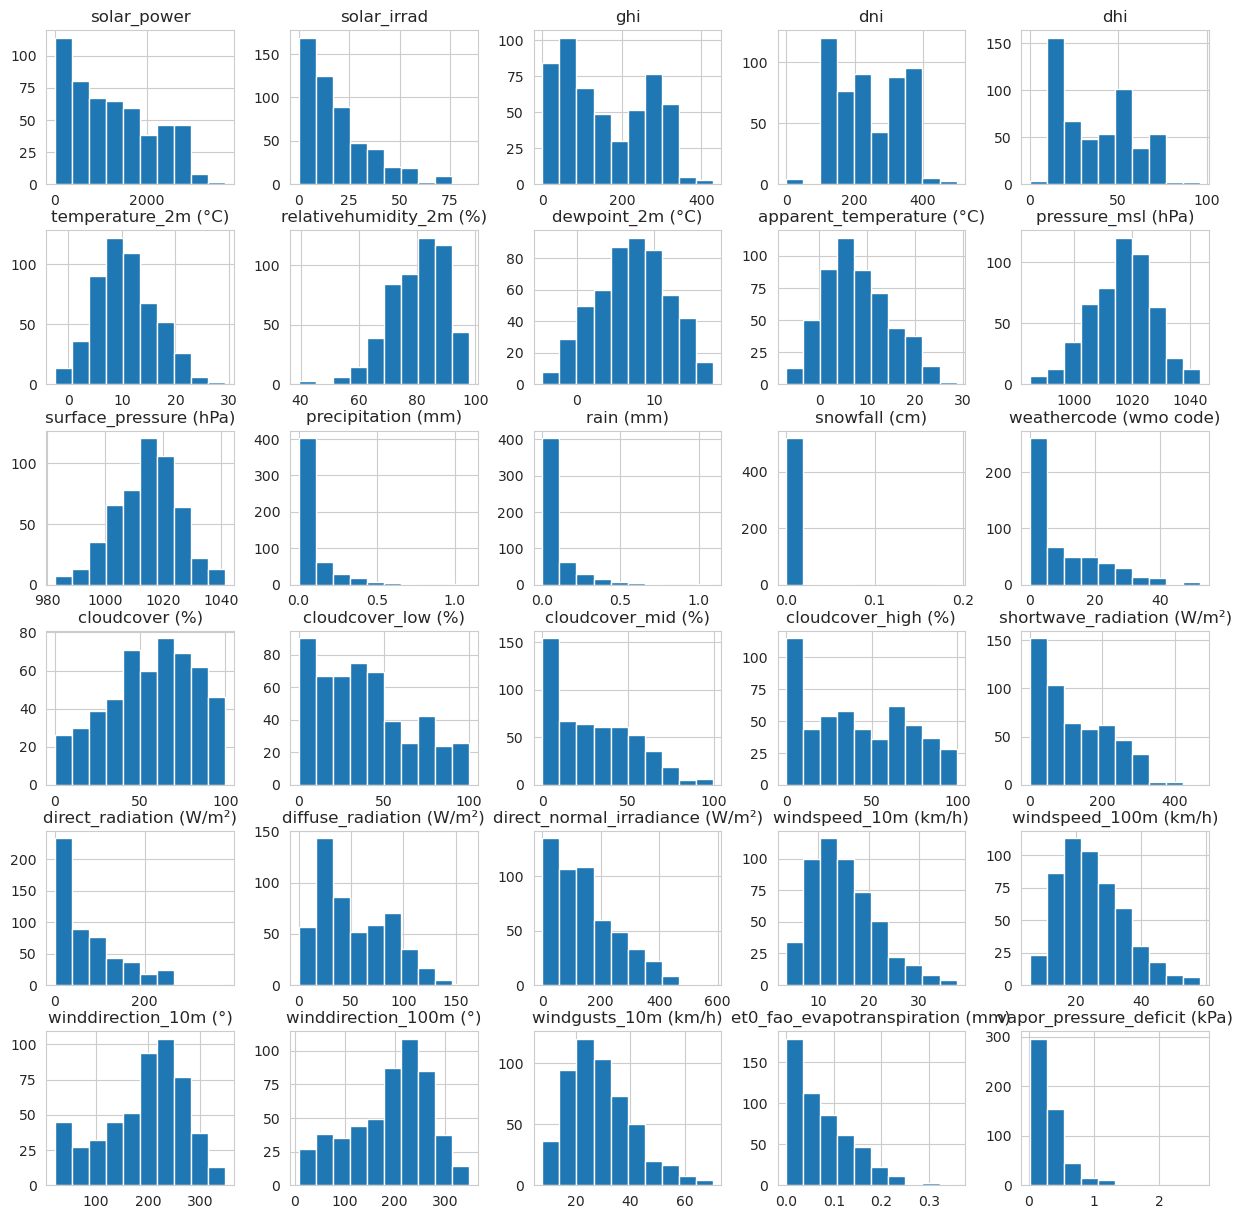

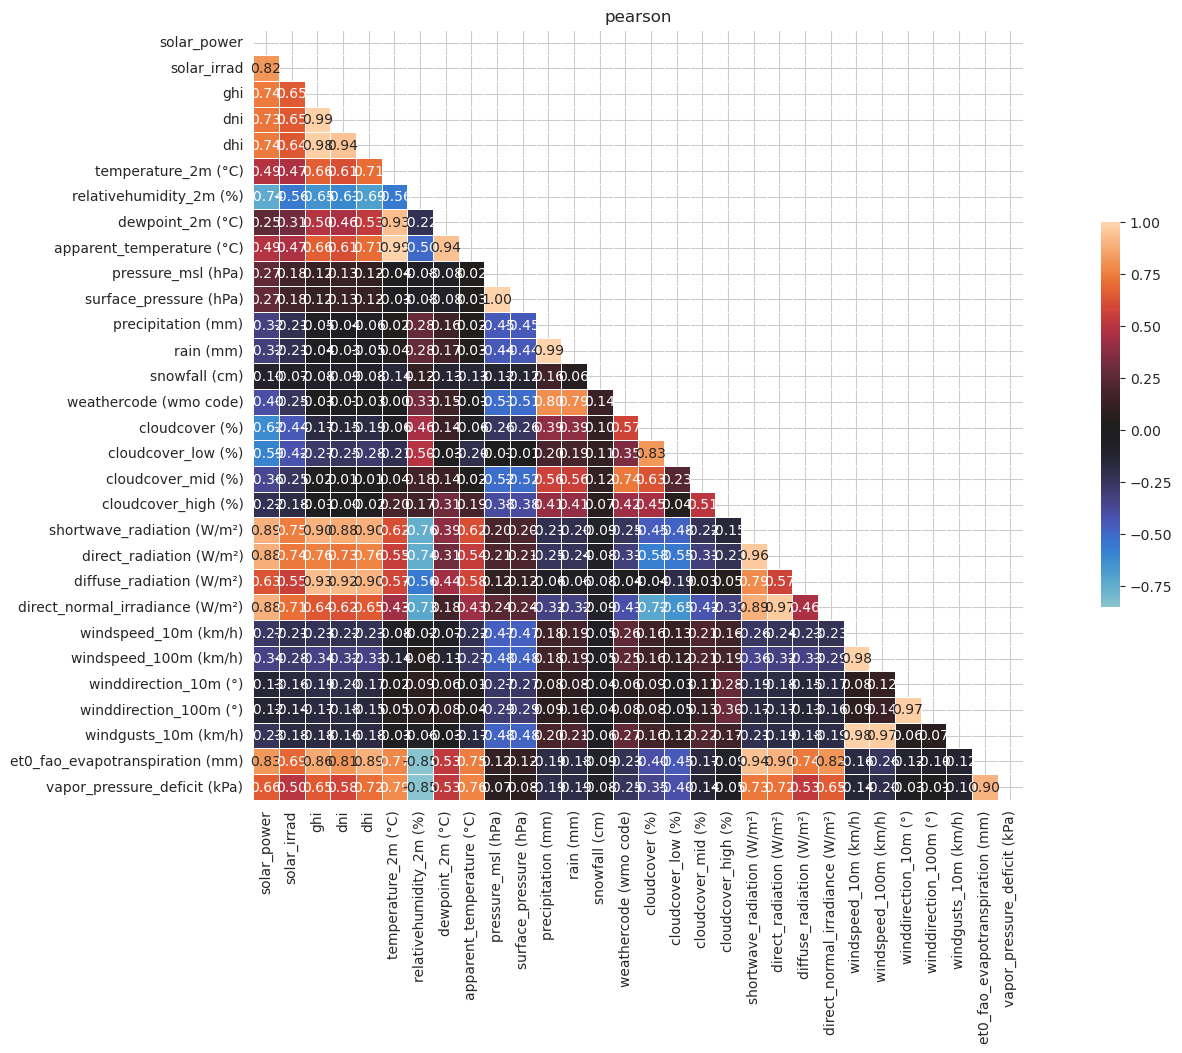

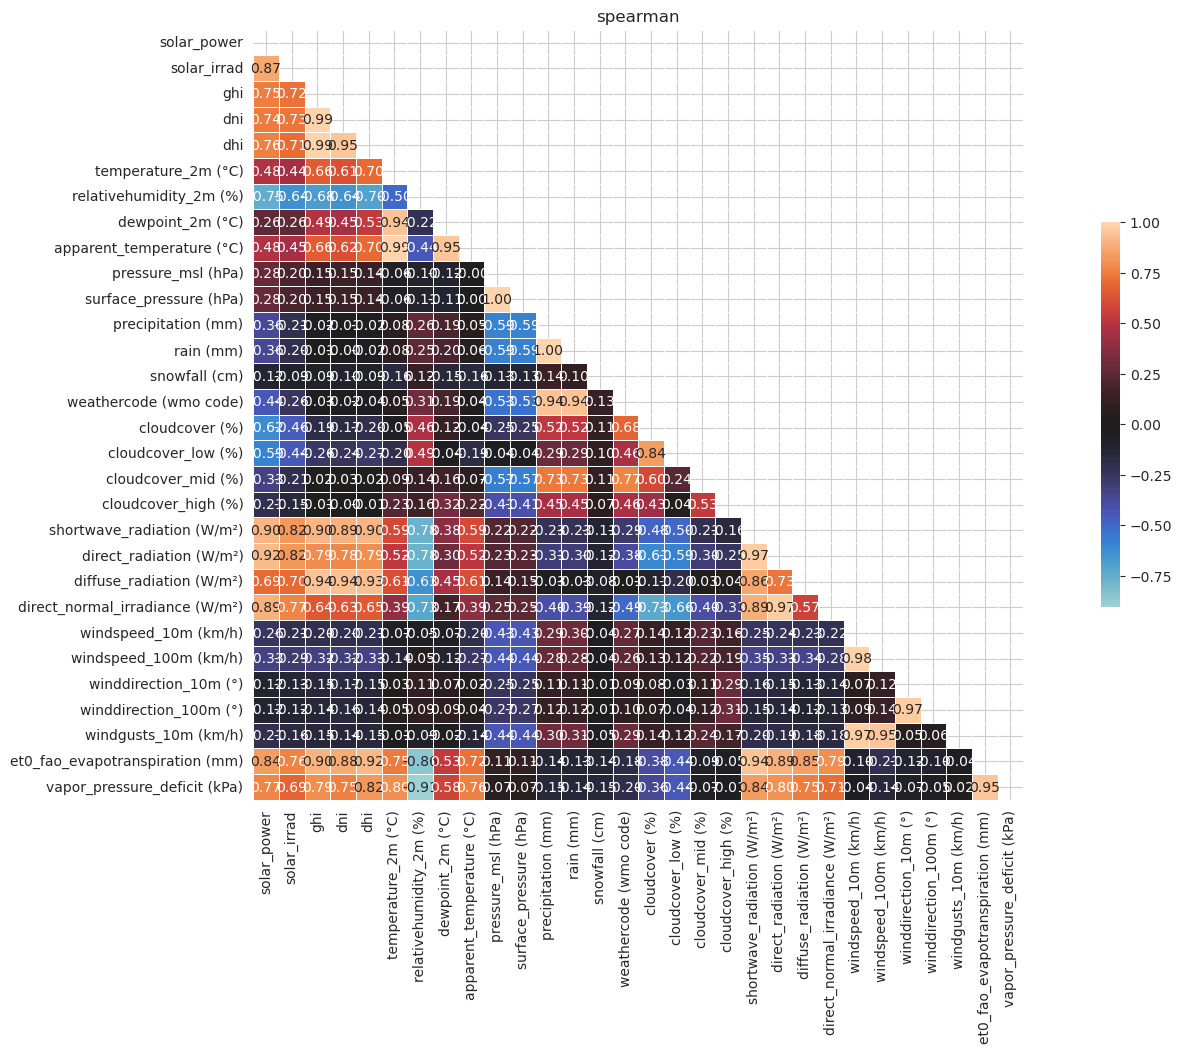

In [25]:
show_info(merged_data_daily)

In [ ]:
test_data =

In [26]:
solar_power_x_train, solar_power_x_test, solar_power_y_train, solar_power_y_test = \
    train_test_split(merged_data_daily[FEATURES_COLUMNS], merged_data_daily[TARGET_COLUMN], test_size=0.35, random_state=42)

In [27]:
solar_power_model = LGBMRegressor()
solar_power_model.fit(solar_power_x_train, solar_power_y_train);

In [28]:
solar_power_prediction = solar_power_model.predict(solar_power_x_test)
solar_power_mse = mean_squared_error(solar_power_y_test, solar_power_prediction)
solar_power_r2 = r2_score(solar_power_y_test, solar_power_prediction)
RMSE = solar_power_mse ** 0.5
MAE = np.mean(np.abs(solar_power_y_test.values - solar_power_prediction))
print(f"{solar_power_mse=} | {solar_power_r2=} | {RMSE=} | {MAE=}")

solar_power_mse=104122.11421755873 | solar_power_r2=0.8752493172737816 | RMSE=322.67958444493934 | MAE=240.66908140034596


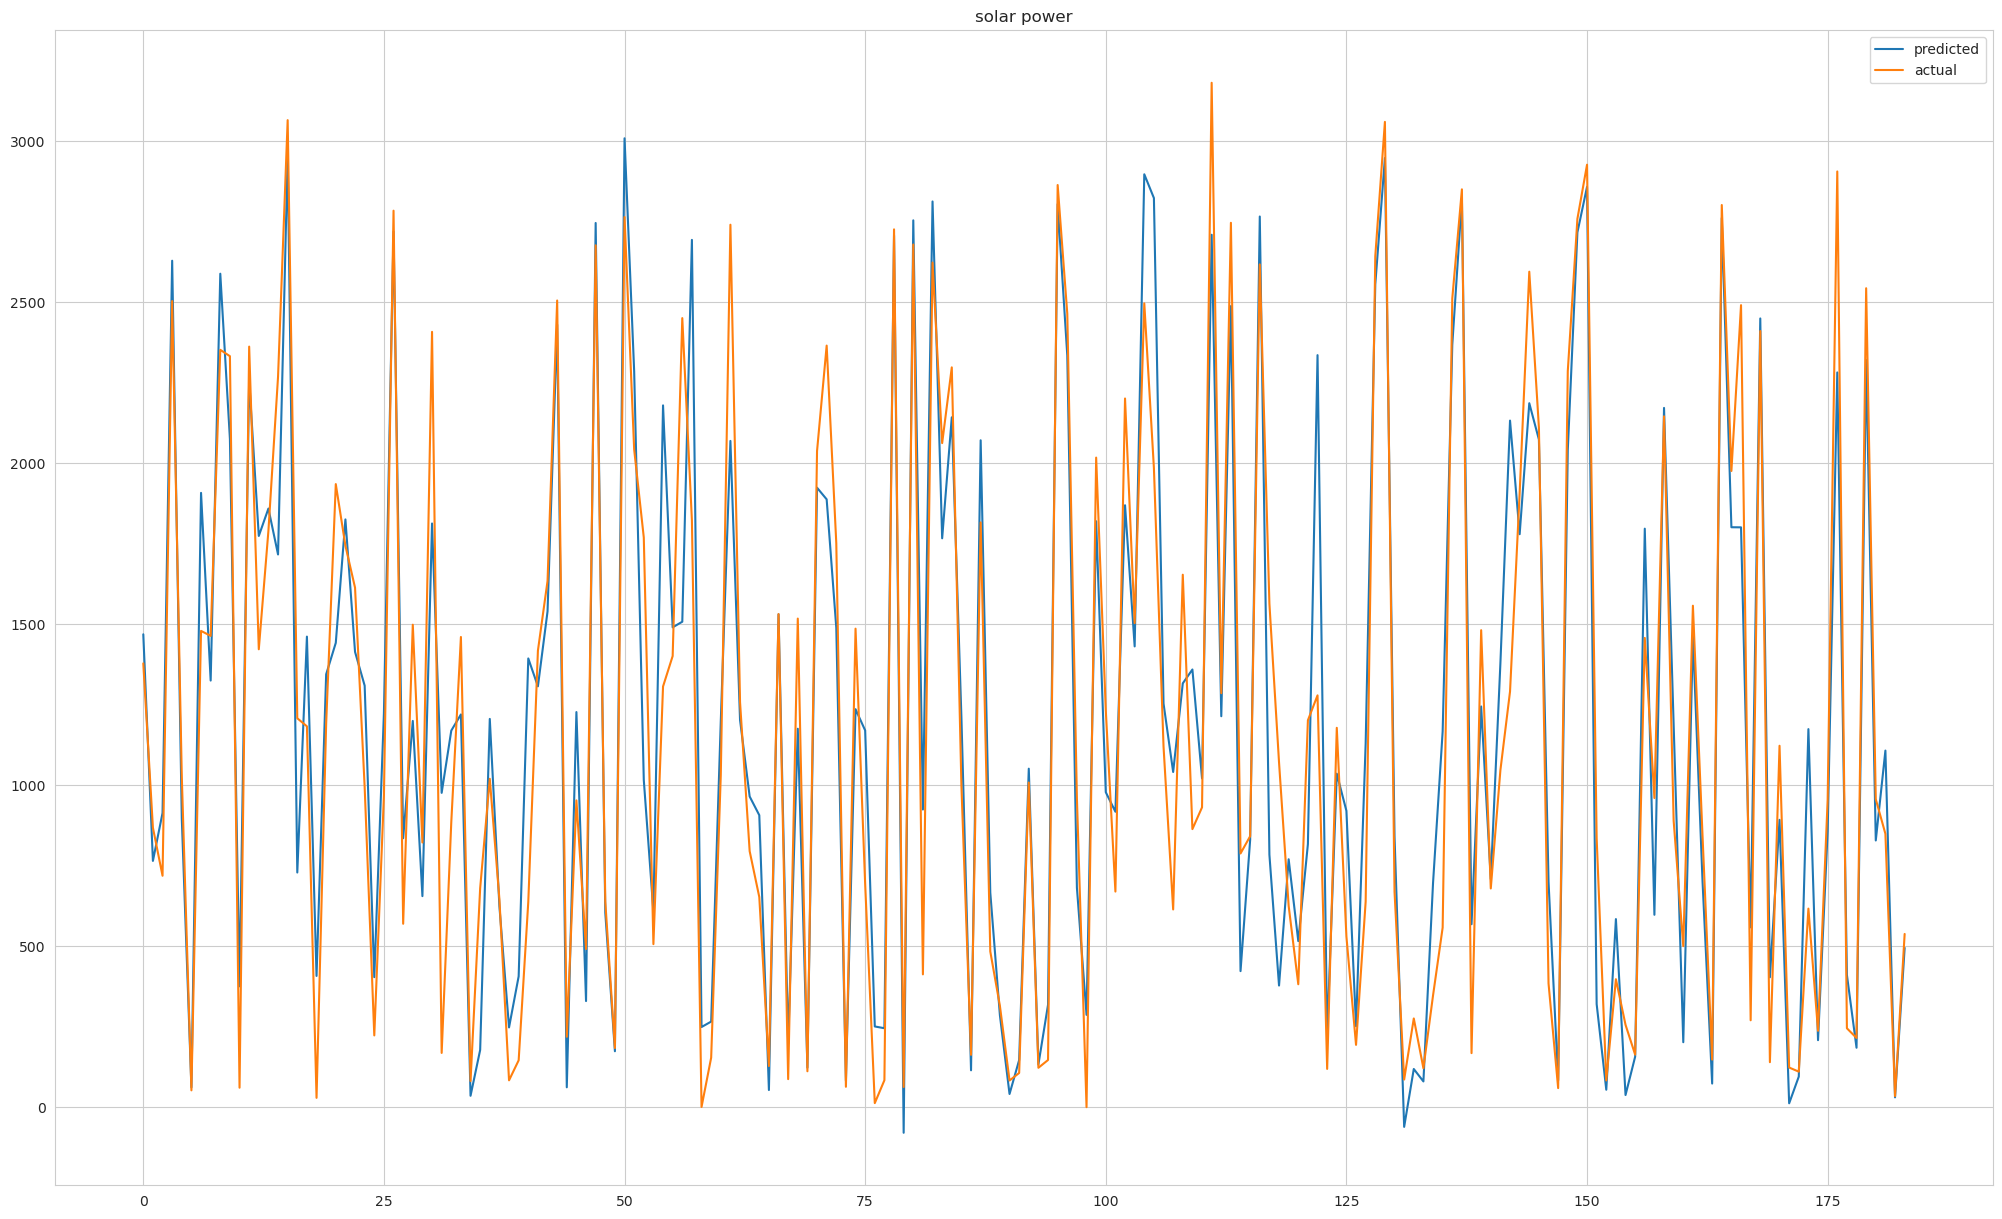

In [29]:
plt.figure(figsize=(25, 15))
plt.plot(solar_power_prediction[-25:], label='predicted')
plt.plot(solar_power_y_test.values[-25:], label='actual')
plt.legend(loc="best")
plt.axis("tight")
plt.title("solar power")
plt.grid(True)

In [25]:
test_data = pd.merge(solar_power_x_test, solar_power_y_test, left_index=True, right_index=True)

In [26]:
test_data["solar_power_prediction"] = solar_power_prediction

In [27]:
error_column = np.abs(solar_power_y_test.values - solar_power_prediction) / solar_power_y_test.values
error_column[error_column == np.inf] = 0.

/tmp/ipykernel_36604/933485727.py:1: RuntimeWarning: divide by zero encountered in divide
  error_column = np.abs(solar_power_y_test.values - solar_power_prediction) / solar_power_y_test.values


In [28]:
test_data["prediction_absolute_error"] = error_column # np.abs(solar_power_y_test.values - solar_power_prediction)

In [29]:
columns = list(reversed(list(test_data.columns[-3:].values))) + list(test_data.columns[:-3].values)
test_data = test_data[columns]

,prediction_absolute_error,solar_power_prediction,solar_power,ghi,dni,dhi,temperature_2m (°C),relativehumidity_2m (%),rain (mm),weathercode (wmo code),cloudcover (%),cloudcover_low (%),cloudcover_mid (%),cloudcover_high (%),shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),windspeed_10m (km/h),windspeed_100m (km/h),vapor_pressure_deficit (kPa)
time,,,,,,,,,,,,,,,,,,,,,
2022-10-07 00:00:00+00:00,0.065569,1468.841323,1378.457000,130.366173,231.183708,32.623728,14.737500,78.625000,0.016667,7.500000,50.166667,34.791667,25.375000,26.125000,119.375000,72.416667,46.958333,176.458333,21.591667,34.704167,0.382500
2022-12-26 00:00:00+00:00,0.118734,764.968002,868.033458,36.377337,121.479913,10.879837,6.837500,83.375000,0.000000,0.666667,23.875000,20.458333,3.791667,11.500000,44.000000,30.083333,13.916667,141.708333,20.170833,33.795833,0.159583
2021-12-02 00:00:00+00:00,0.271214,913.771359,718.817667,41.489069,126.259088,12.619102,2.141667,71.666667,0.000000,0.541667,18.333333,7.791667,12.375000,12.833333,51.291667,35.833333,15.458333,152.437500,20.329167,33.466667,0.204583
2022-06-03 00:00:00+00:00,0.050047,2629.221482,2503.908875,311.911989,376.771631,66.690952,15.212500,76.833333,0.029167,9.166667,26.000000,1.500000,23.708333,34.333333,284.041667,187.583333,96.458333,298.412500,15.445833,24.550000,0.438750
2022-02-14 00:00:00+00:00,0.127576,896.286731,1027.352250,89.875965,196.700095,23.109441,8.012500,82.208333,0.191667,18.666667,71.041667,41.875000,55.958333,56.375000,88.375000,57.625000,30.750000,175.712500,22.450000,36.137500,0.195417


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2022-10-07 00:00:00+00:00 to 2022-12-01 00:00:00+00:00
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   prediction_absolute_error        184 non-null    float64
 1   solar_power_prediction           184 non-null    float64
 2   solar_power                      184 non-null    float64
 3   ghi                              184 non-null    float64
 4   dni                              184 non-null    float64
 5   dhi                              184 non-null    float64
 6   temperature_2m (°C)              184 non-null    float64
 7   relativehumidity_2m (%)          184 non-null    float64
 8   rain (mm)                        184 non-null    float64
 9   weathercode (wmo code)           184 non-null    float64
 10  cloudcover (%)                   184 non-null    float64
 11  cloudcover_low (%)               18

None

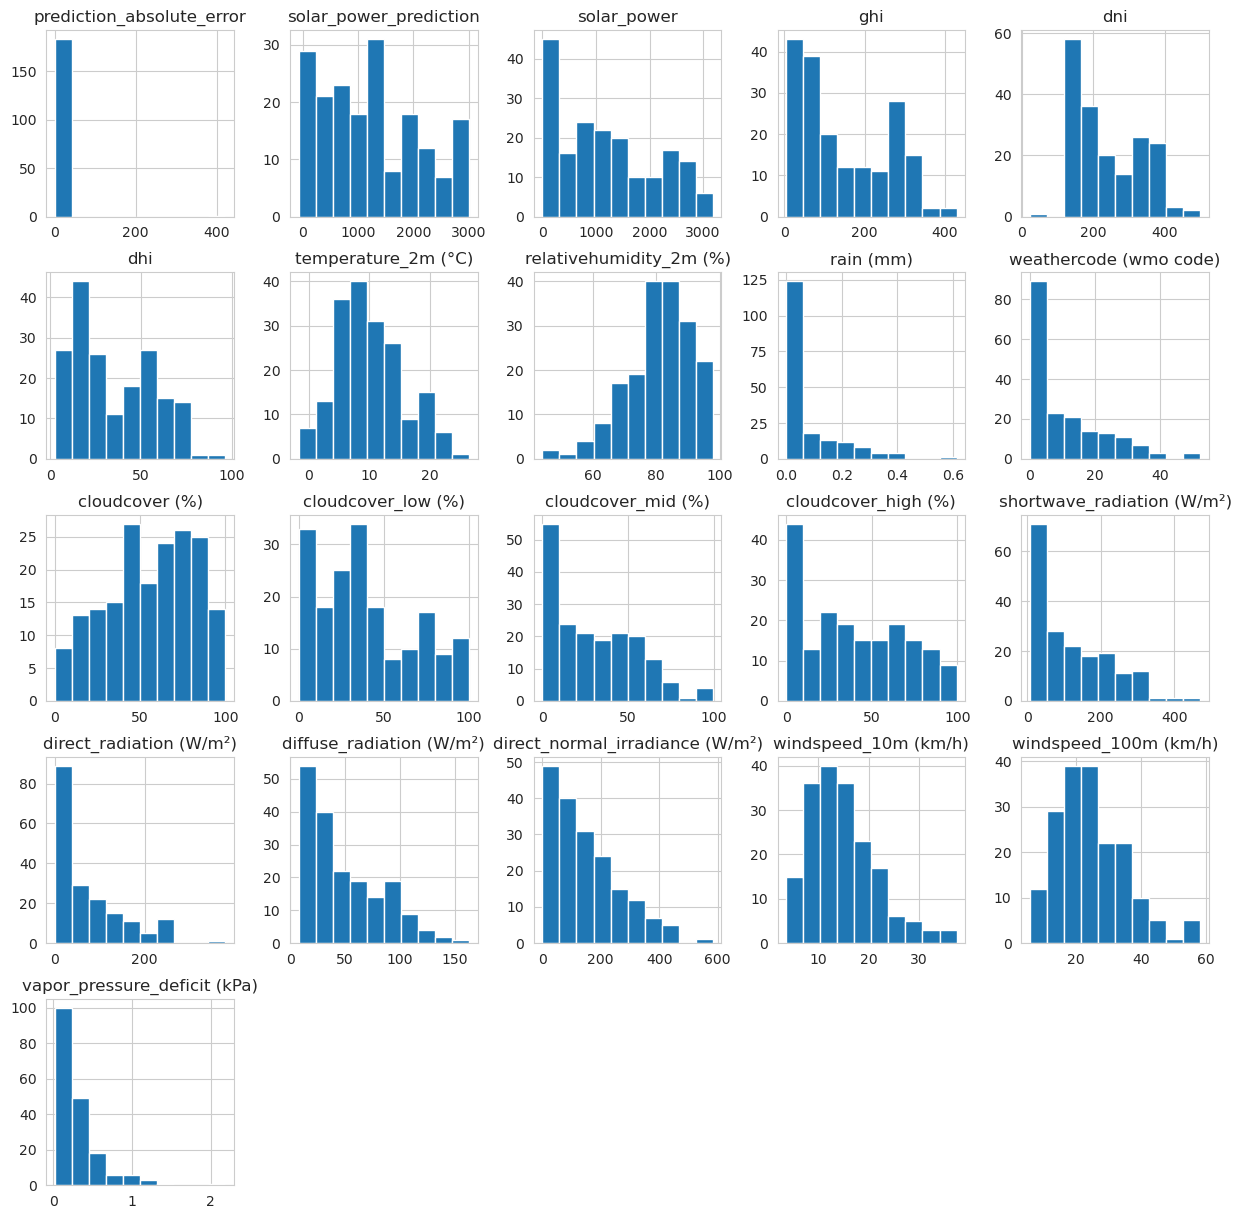

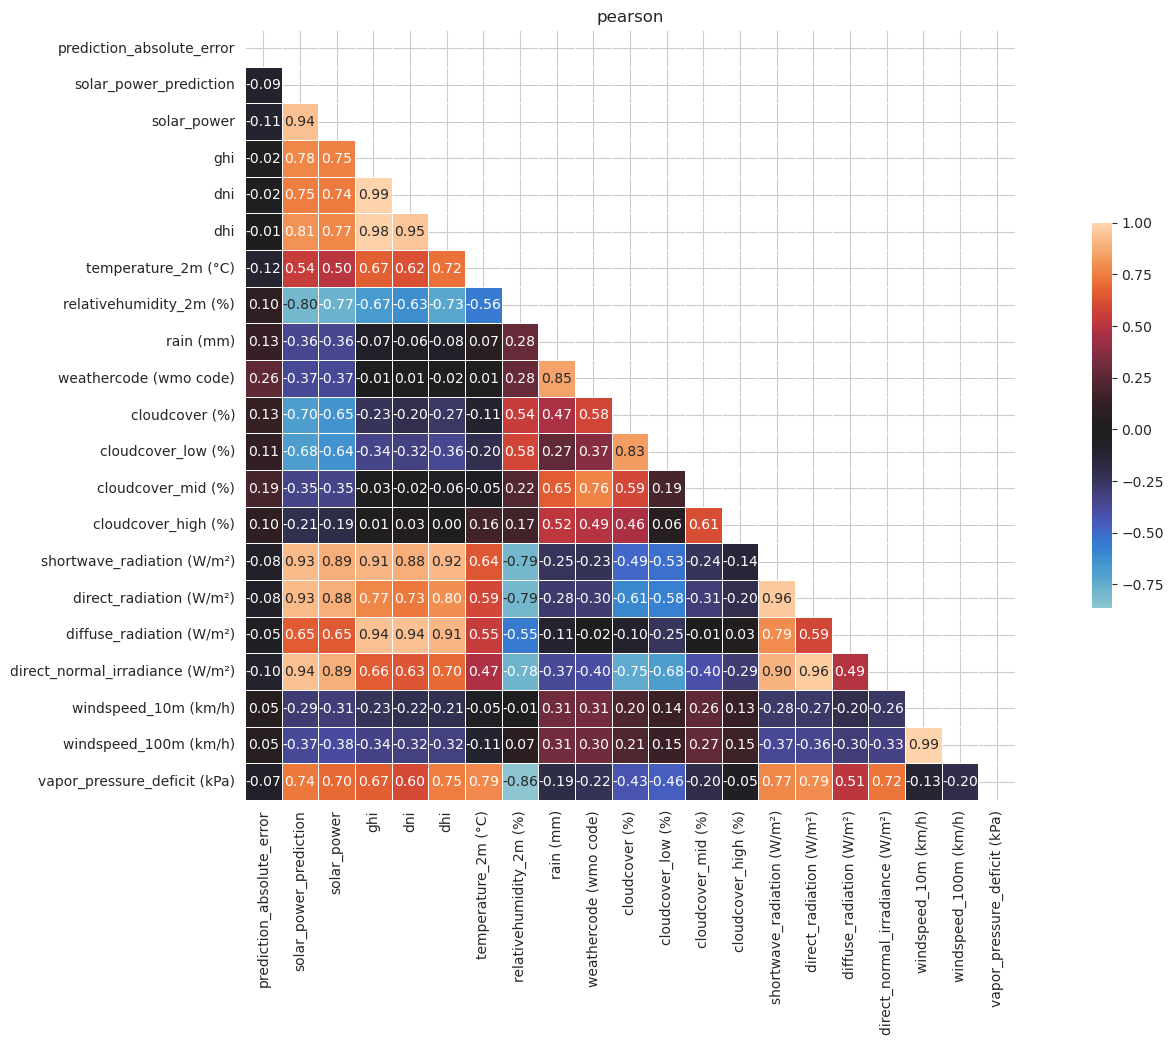

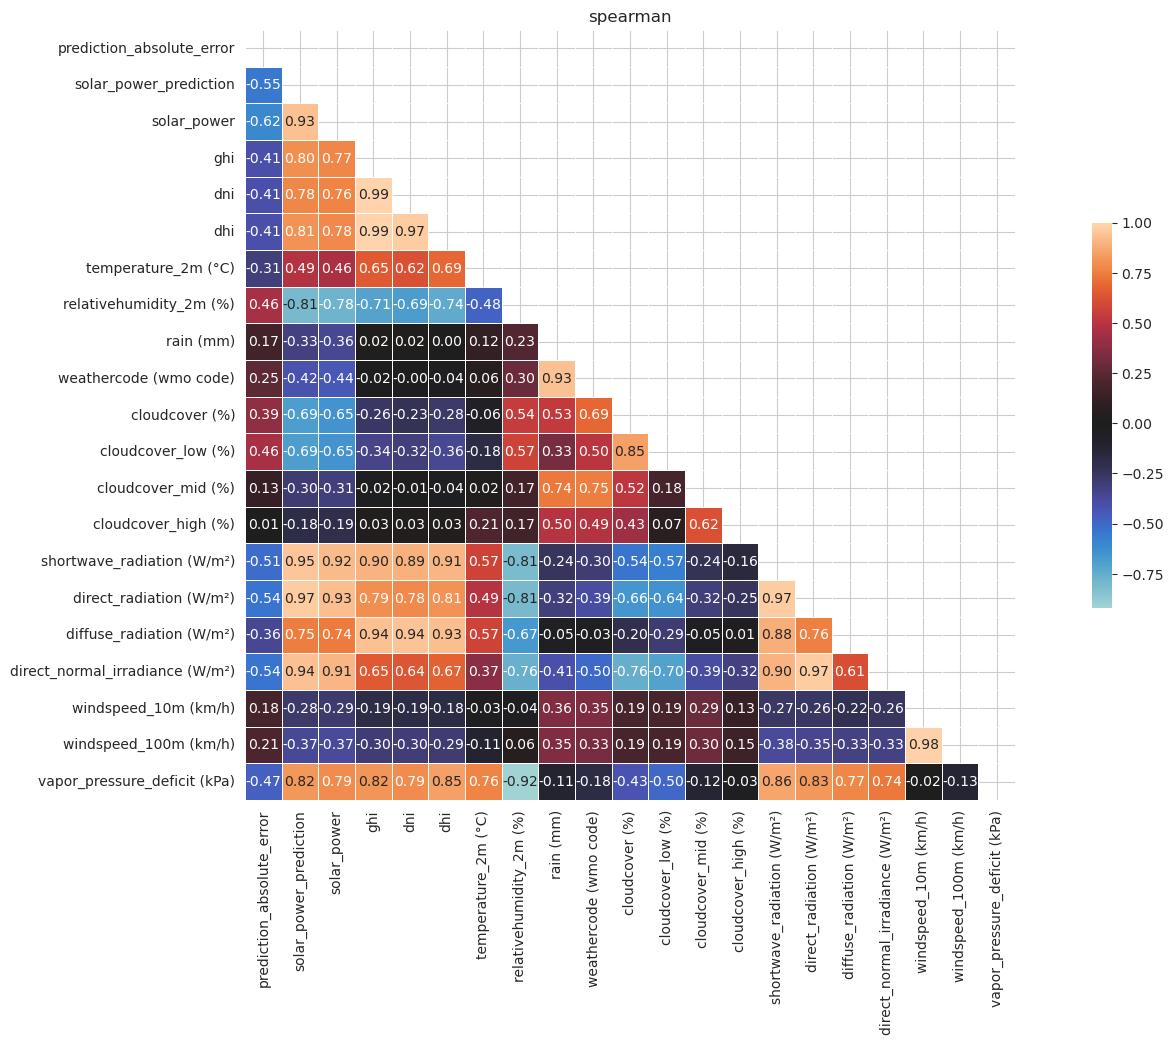

In [30]:
show_info(test_data)

<Axes: >

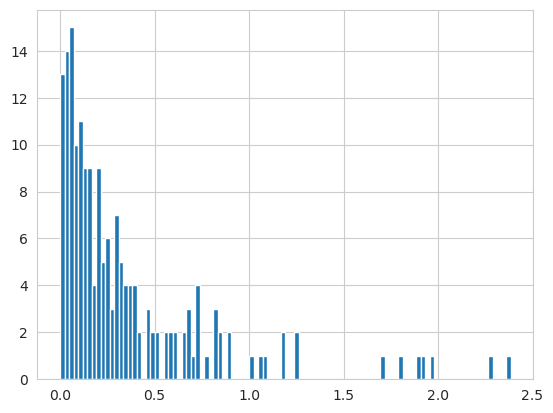

In [31]:
test_data[test_data["prediction_absolute_error"] <= 3]["prediction_absolute_error"].hist(bins = 100)

In [34]:
bad_days = test_data[test_data["prediction_absolute_error"] < 400]

<Axes: xlabel='time'>

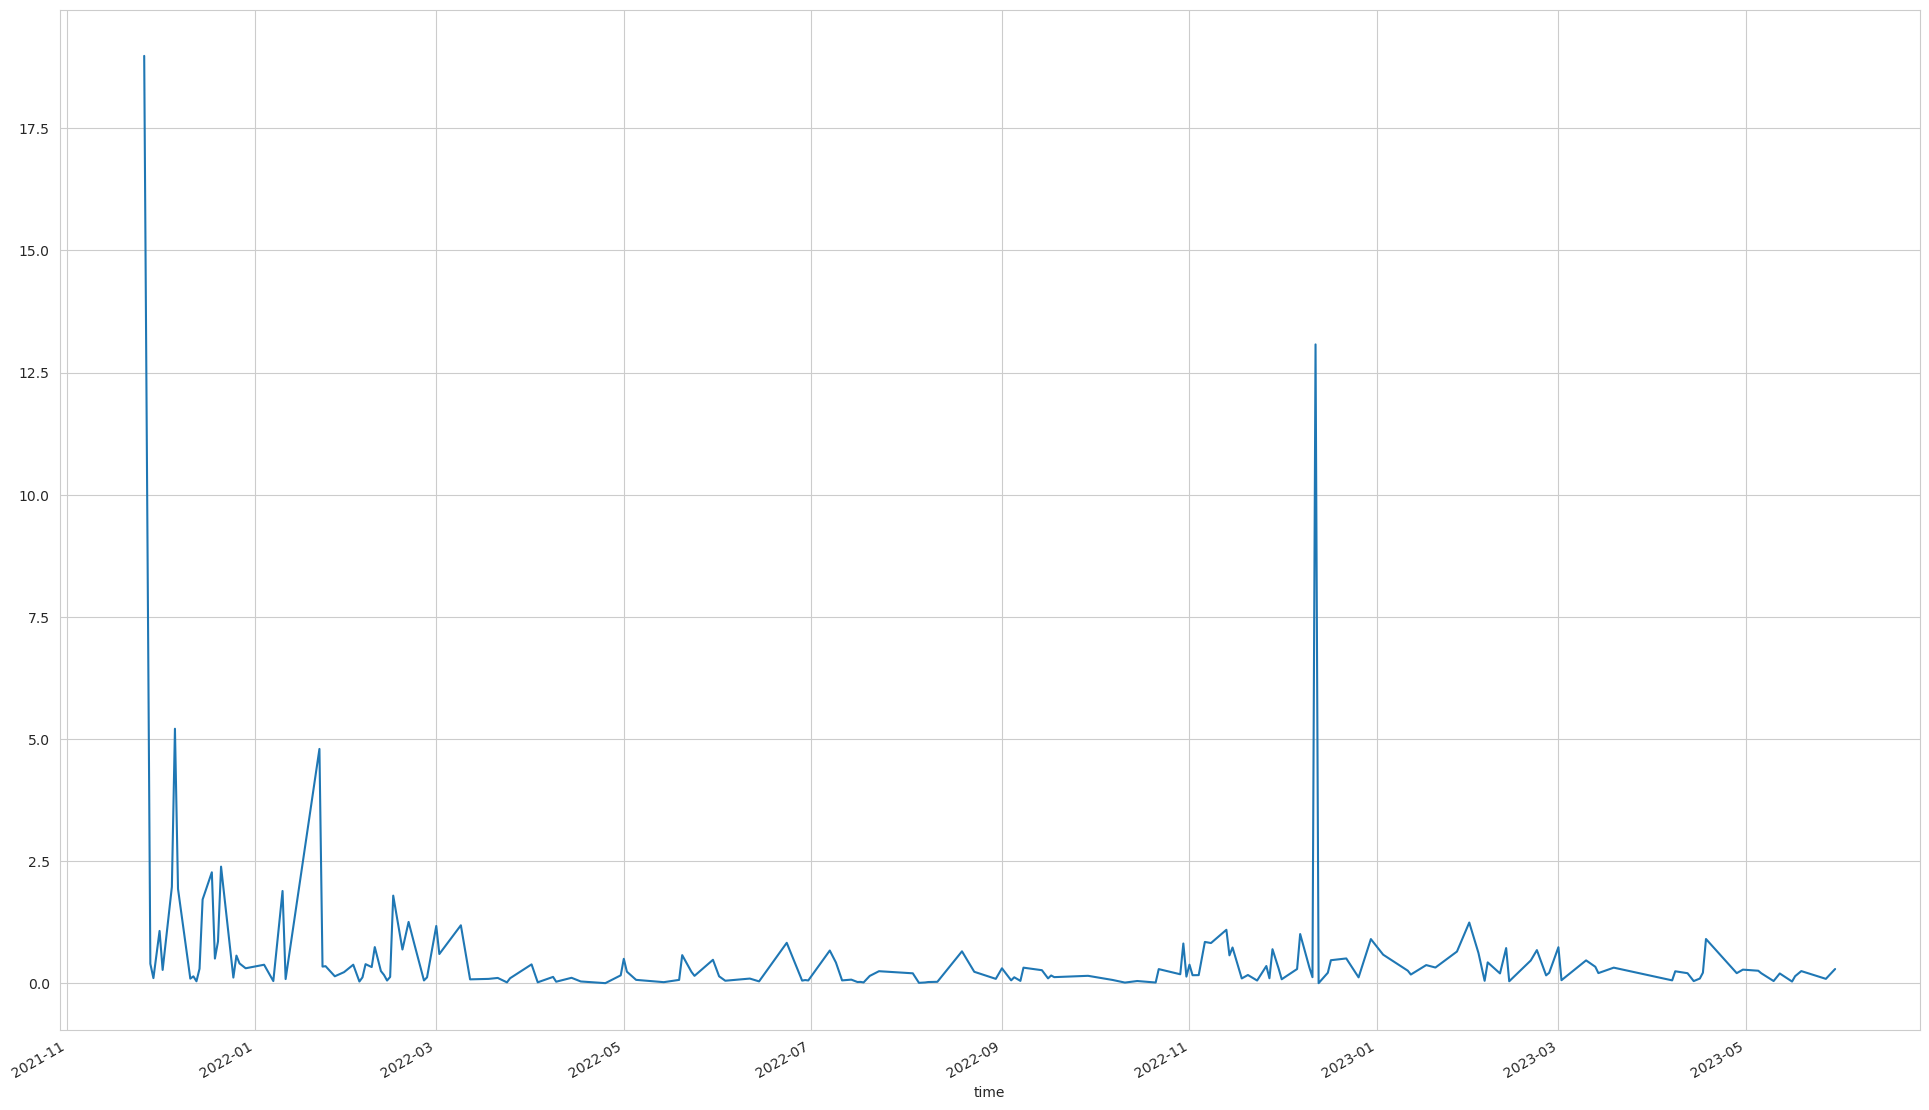

In [35]:
plt.figure(figsize=(24, 15))
bad_days.prediction_absolute_error.plot()